<a href="https://colab.research.google.com/github/nihalaltay/Spanish-Turkish-music-group-name-generator-models/blob/main/NLP_A3_Smaller_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
#---*-**-*--- Spanish Band Name Generator Model ---*-**-*---#

# Form the dataset: Get Spanish band names

# Direct download link
download_url = 'https://drive.google.com/uc?export=download&id=1e_i08fhp4xMWSfDxlFuPAaakouwDTQyT'

# Load the CSV file (dfs: dataframe spanish)
dfs = pd.read_csv(download_url, header=None)

# Preview the first few rows
print(dfs.head())

                  0
0      21 Japonesas
1           A Bordo
2  A las 10 en casa
3      Trío Acuario
4          Aguaviva


In [ ]:
# Process the dataset. Make it into a list. Removing dots too, because they conflict with dots within the band names, hindering the training.
es_bands = dfs[0].dropna().str.lower().str.replace('.', '', regex=False).tolist()

# Preview the first few elements
print(es_bands[:10])

['21 japonesas', 'a bordo', 'a las 10 en casa', 'trío acuario', 'aguaviva', 'alaska y los pegamoides', 'álex & christina', 'alive', 'amatria', 'amelie']


In [ ]:
len(es_bands)

305

In [ ]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(es_bands))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: '!', 3: '&', 4: "'", 5: ',', 6: '-', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '7', 14: '8', 15: '9', 16: 'a', 17: 'b', 18: 'c', 19: 'd', 20: 'e', 21: 'f', 22: 'g', 23: 'h', 24: 'i', 25: 'j', 26: 'k', 27: 'l', 28: 'm', 29: 'n', 30: 'o', 31: 'p', 32: 'q', 33: 'r', 34: 's', 35: 't', 36: 'u', 37: 'v', 38: 'w', 39: 'x', 40: 'y', 41: 'z', 42: 'à', 43: 'á', 44: 'ä', 45: 'é', 46: 'í', 47: 'ñ', 48: 'ó', 49: 'ú', 0: '.'}


In [ ]:
# Build the new dataset
block_size = 3 # context length: how many characters do we take to predict the next one.

def build_dataset(es_bands):
  X, Y = [], []
  for w in es_bands:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(es_bands)
n1 = int(0.8*len(es_bands))
n2 = int(0.9*len(es_bands))

Xtr, Ytr = build_dataset(es_bands[:n1])
Xdev, Ydev = build_dataset(es_bands[n1:n2])
Xte, Yte = build_dataset(es_bands[n2:])

torch.Size([3055, 3]) torch.Size([3055])
torch.Size([347, 3]) torch.Size([347])
torch.Size([382, 3]) torch.Size([382])


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((50, 5), generator=g)
W1 = torch.randn((15, 50), generator=g)
b1 = torch.randn(50, generator=g)
W2 = torch.randn((50, 50), generator=g)
b2 = torch.randn(50, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

3600

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
#Model Training

num_iterations = 30000
batch_size = 32

for i in range(num_iterations):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]] # (batch_size, 3, 10)
  h = torch.tanh(emb.view(-1, 15) @ W1 + b1)
  logits = h @ W2 + b2 # (batch_size, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # learning rate schedule
  if i < 5000:
    lr = 0.005
  elif i < 10000:
    lr = 0.001
  else:
    lr = 0.0001

  # parameter update
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

  if i % 5000 == 0:  # Print progress every 5000 steps
    print(f"Iteration {i}, Loss: {loss.item():.4f}")

Iteration 0, Loss: 15.9440
Iteration 5000, Loss: 4.2640
Iteration 10000, Loss: 3.5119
Iteration 15000, Loss: 2.9629
Iteration 20000, Loss: 3.8278
Iteration 25000, Loss: 3.5201


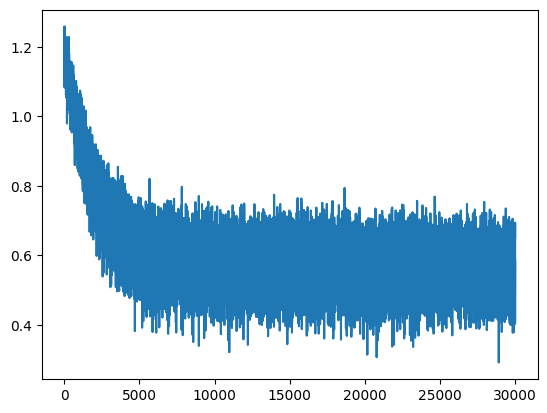

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 15) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(3.6995, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 15) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(4.1675, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 15) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(4.3124, grad_fn=<NllLossBackward0>)

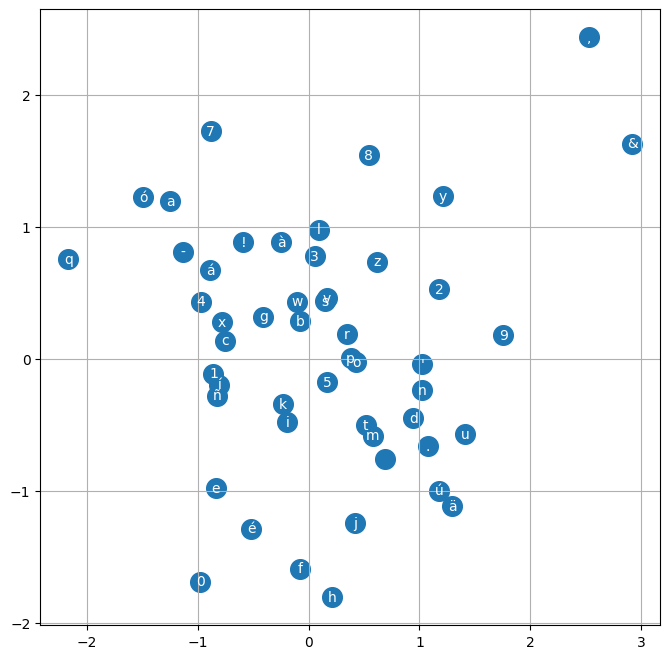

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

lefney.
i massel kmono pasenjadey qzol1r.
los ilmaiso.
ravaa.
cresantbe.
i cglñífoeú.
elaan.
dortic0jnierrñllakr.
hecmqpié0ññuazf8,a5&,5dmazsir.
los.
cuge odesnnli1miiralis.
dfhpi!s.
la í  reg.
elag.
el9oúean.
austbe.
luiagaàa lpoclues nrl1fmenmel y 9pm,,r.
rihri!nyivestil9ezmbhvises q enestqnen2gow k7o3mu,al 7oaúines r1snlpkzob.
i0jnasener.
los sra.


In [ ]:
#---*-**-*--- Turkish Band Name Generator Model ---*-**-*---#

# Form the dataset: Get Turkish band names

# Direct download link
download_url = 'https://drive.google.com/uc?export=download&id=1lNyu8CGxheZtdQgSad7LzDo7o9OX9lPQ'

# Load the CSV file (dft: dataframe turkish)
dft = pd.read_csv(download_url, header=None)

# Preview the first few rows
print(dft.head())

               0
0            657
1     80 Kalibre
2     100 Derece
3            110
4  Altıncı Cadde


In [ ]:
# Process the dataset. Make it into a list. Removing dots too, because they conflict with dots within the band names, hindering the training.
tr_bands = dft[0].dropna().str.lower().str.replace('.', '', regex=False).tolist()

# Preview the first few elements
print(tr_bands[:10])

['657', '80 kalibre', '100 derece', '110', 'altıncı cadde', 'acil servis', 'aduuket', 'adamlar', 'akbaba', 'almora']


In [ ]:
len(tr_bands)

268

In [ ]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(tr_bands))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: '&', 3: '-', 4: '0', 5: '1', 6: '2', 7: '3', 8: '5', 9: '6', 10: '7', 11: '8', 12: 'a', 13: 'b', 14: 'c', 15: 'd', 16: 'e', 17: 'f', 18: 'g', 19: 'h', 20: 'i', 21: 'j', 22: 'k', 23: 'l', 24: 'm', 25: 'n', 26: 'o', 27: 'p', 28: 'r', 29: 's', 30: 't', 31: 'u', 32: 'v', 33: 'x', 34: 'y', 35: 'z', 36: 'ç', 37: 'ö', 38: 'ü', 39: 'ğ', 40: 'ı', 41: 'ş', 42: '̇', 0: '.'}


In [ ]:
# Build the new dataset
block_size = 3 # context length: how many characters do we take to predict the next one.

def build_dataset(tr_bands):
  X, Y = [], []
  for w in tr_bands:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(tr_bands)
n1 = int(0.8*len(tr_bands))
n2 = int(0.9*len(tr_bands))

Xtr, Ytr = build_dataset(tr_bands[:n1])
Xdev, Ydev = build_dataset(tr_bands[n1:n2])
Xte, Yte = build_dataset(tr_bands[n2:])

torch.Size([2215, 3]) torch.Size([2215])
torch.Size([295, 3]) torch.Size([295])
torch.Size([259, 3]) torch.Size([259])


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((43, 5), generator=g)
W1 = torch.randn((15, 50), generator=g)
b1 = torch.randn(50, generator=g)
W2 = torch.randn((50, 43), generator=g)
b2 = torch.randn(43, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

3208

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
#Model Training

num_iterations = 30000
batch_size = 32

for i in range(num_iterations):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]] # (batch_size, 3, 10)
  h = torch.tanh(emb.view(-1, 15) @ W1 + b1)
  logits = h @ W2 + b2 # (batch_size, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # learning rate schedule
  if i < 5000:
    lr = 0.005
  elif i < 10000:
    lr = 0.001
  else:
    lr = 0.0001

  # parameter update
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

  if i % 5000 == 0:  # Print progress every 5000 steps
    print(f"Iteration {i}, Loss: {loss.item():.4f}")

Iteration 0, Loss: 17.1246
Iteration 5000, Loss: 4.3711
Iteration 10000, Loss: 4.0156
Iteration 15000, Loss: 3.9661
Iteration 20000, Loss: 3.8484
Iteration 25000, Loss: 4.7220


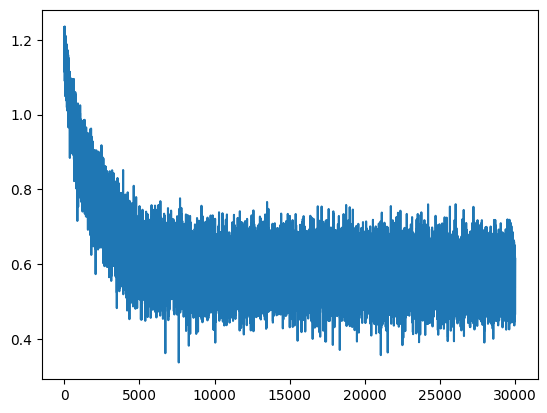

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 15) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(3.7788, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 15) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(4.4279, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 15) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(4.6089, grad_fn=<NllLossBackward0>)

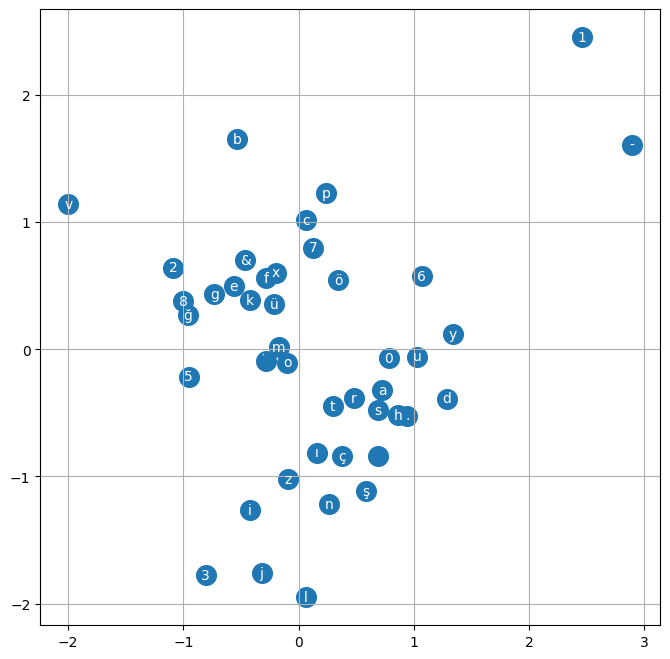

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(min(C.shape[0], len(itos))):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

bi̇ı akn ootiekl k.
an aolihkemateö.
apypsponnorgauaaıkadeelj .
eemd tle gi.
enki.
oan eoc.
hosuedçık3.
tppykncaglihxkueameldrr.
uosuşuöin3.
yap.
bay.
aod.
rkd tğ  .
5v eıklnaodnmsyu7raeustlsdkai.
llkvidstledgemizmzaöüueıklemi.
vv8kdanll.
ıtgkdaalu.
fdur.
akeuelgaa ısyitze ki.
ez.
